In [1]:
import sys
import numpy as np
import random
import copy
from time import time
import matplotlib.pyplot as plt
import pickle
import math


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#directory = "/content/drive/MyDrive/Universidad/4.Maila/BH/BH laboak/BH Praktika/"
directory = "/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/"
#directory = ""

sys.path.append(directory)

In [5]:
from ipynb.fs.full.CDP_Sarrera_Ikasle import sortu_grafoa, bistaratu_grafoa
from ipynb.fs.full.CDP_1_fasea_Ikasle import modularitatea

In [6]:
G = sortu_grafoa() #Grafoa sortu
n = G.number_of_nodes() #n= nodo kopurua
k=5 #k = komunitate kopurua (guk zehaztua)

In [7]:
G.number_of_edges()

3215

In [8]:
#Grafoa, komunitate kopurua eta nodo kopurua emanda ausazko soluzio bat itzultzen du
def sortu_soluzioa(G,k,n):
  return np.random.randint(k,size=n)

#Ingurune funtzioak

In [9]:
#Sortu ausazko zenbaki bat emandako tarteetan eta x ez dena.
def randint_exclude(start,end,x):
  y = np.random.randint(start,end)

  while x == y:
    y= np.random.randint(start,end)
  return y

#Sortu ausazko bektore bat, emandakoaren dimentsio berekoa eta bere zenbakiak errepikatu gabe.
def randvec(diag):
  vec = np.empty(shape=len(diag))
  for i in range(len(diag)):
    vec[i] = randint_exclude(0,k-1,diag[i])
  return vec

def hamming_auzokide(solution,i,j):
  auzokide = np.copy(solution)
  auzokide[i] = randint_exclude(0,k-1,auzokide[i])
  return auzokide, i+1,j



In [10]:
#Emandako (i,j) indizeek definitzen duten insert eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_insert(i,j): #i==n denean bukatu behar da
  j_ = j+1
  if j_ == i:
    j_ +=2
  if j_ == i+1:
    j_ +=1
  if j_>n:
    return i+1,0
  return i,j_ 

#Insert inguruneko auzokide bat itzultzen du, emandako (i,j) insert eragiketa kontuan hartuta (i elementua j posizioan txertatu)
#Bestela konbinazio gehiegi (n^2-n), eta RAM memoria xahutzen da.
def insert_auzokide(solution, i=0,j=2):

  neighbour = list(solution)
  neighbour.insert(j,neighbour[i])
  if j>i:
    neighbour.pop(i) #Kendu listatik hasieran zegoen agerpena
  else:
    neighbour.pop(i+1) #Kendu listatik hasieran zegoen agerpena (j<i denez eskuinera mugitu da)
  neighbour = np.asarray(neighbour)

  i,j = hurrengo_insert(i,j)

  return neighbour,i,j

In [11]:
#Emandako (i,j) indizeek definitzen duten swap eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_swap(i,j): #i==n denen bukatu behar da
  j_ = j+1
  if j_ == i:
    j_ +=1
  if j_>=n:
    return i+1,i+2
  return i,j_ 

#Swap inguruneko auzokide bat itzultzen du, emandako (i,j) swap eragiketa kontuan hartuta (i eta j posizioetako elementuak trukatu)
def swap_auzokide(solution, i=0,j=1):

  neighbour = np.copy(solution)
  neighbour[i],neighbour[j] = neighbour[j],neighbour[i]

  i,j = hurrengo_swap(i,j)

  return neighbour,i,j

#Aldagai globalak

In [12]:
#ALDAGAI GLOBALAK HASIERATU

#Nodoen izenen lista (indizetik izenera pasatzeko)
nodoak = list(G.nodes)

#Grafoko ertz guztien pisuen batura
m = G.size(weight="weight") 

#Nodoen izenetatik indizera pasatzeko hiztegia
indizeak = dict()
ind = 0
for nodo in nodoak:
  indizeak[nodo] = ind
  ind+=1

#Lortu nodo batetik besterako ertzen pisuen matrizea (ertza ez badago pisua=0)
pisuak = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      lag = G[nodoak[i]]
      if  nodoak[j] in lag: #dira auzokideak
          pisuak[i,j] = lag[nodoak[j]]["weight"]

#Nodoen graduak eskuratzeko. Dena den, guk graduak erabili ordez nodoari konektatutako ertzen pisuen baturak erabiliko ditugu modularitatean.
# graduak = []
# for i in range(n):
#   graduak.append(G.degree(nodoak[i]))

#Nodo baten gradua beregana konektatutako ertz guztien pisuen batura kontsideratuko dugu
graduak = []
for i in range(n):
  graduak.append(np.sum(pisuak[i]))

#Modularitate funtziorako aurrekalkulatu i eta j nodo pare posible guztien graduen biderketak 
graduMul = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      graduMul[i,j] = graduak[i]*graduak[j]/(2*m)

#Modularitate funtziorako aurrekalkulatu i eta j nodo pare posible guztien aportazioak edo kontribuzioak
contributions = (pisuak - graduMul)/(2*m)

swap_ijs = []
i,j = 0,1
while i<n and j<n:
  swap_ijs.append((i,j))
  i,j = hurrengo_swap(i,j)

insert_ijs = []
i,j = 0,2
while i<n:
  insert_ijs.append((i,j))
  i,j = hurrengo_insert(i,j)

Emin = pickle.load(open("/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/Emin","rb"))
Emax = pickle.load(open("/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/Emax","rb"))

#Modularitatea

In [13]:
ii, jj = np.ogrid[:n, :n]
def modularitatea(G, solution):
    value = np.sum(np.where(solution[ii]==solution[jj], contributions[ii,jj], 0)) 
    return value

#Soluzio bakarrean oinarritutako algoritmoa: Simulated Annealing

In [14]:
def modularitate_auzokide(solution,neighbour,oldmod,i,j,func = "hamming"):
  mod = oldmod
  if func == "hamming":
    mod -= np.sum(np.where(solution[ii]==solution[i], contributions[ii,i], 0))*2
    mod += np.sum(np.where(neighbour[ii]==j, contributions[ii,i], 0)) *2
  elif func == "swap":
    mod -= np.sum(np.where(solution[ii]==solution[i], contributions[ii,i], 0)) *2
    mod -= np.sum(np.where(solution[ii]==solution[j], contributions[ii,j], 0)) *2
    mod += np.sum(np.where(neighbour[ii]==neighbour[i], contributions[ii,i], 0)) *2
    mod += np.sum(np.where(neighbour[ii]==neighbour[j], contributions[ii,j], 0)) *2
  
  else:

    return modularitatea(G,neighbour)
    if i<j:
      low = i
      high = j
    else:
      low = j
      high = i+1

    tartea = np.arange(low,high)
    besteak = np.concatenate((np.arange(0,low) , np.arange(high,n)) , axis=0)
    for k in range(low,high):
      mod -= np.sum(np.where(solution[tartea]==solution[k], contributions[tartea,k], 0)) 
      mod -= np.sum(np.where(solution[besteak]==solution[k], contributions[besteak,k], 0)) *2
      mod += np.sum(np.where(neighbour[tartea]==neighbour[k], contributions[tartea,k], 0)) 
      mod += np.sum(np.where(neighbour[besteak]==neighbour[k], contributions[besteak,k], 0)) *2

  return mod

In [15]:
swap_ijs = []
i,j = 0,1
while i<n and j<n:
  swap_ijs.append((i,j))
  i,j = hurrengo_swap(i,j)

insert_ijs = []
i,j = 0,2
while i<n:
  insert_ijs.append((i,j))
  i,j = hurrengo_insert(i,j)


In [16]:
def T_kalkulatu(prob):
  T = 1
  k = 0
  x_t = -1
  p=2 #edozein balio >1
  N = len(Emin)
  epsilon = 0.001
  while k<N and abs(x_t-prob)>epsilon:
    x_t = np.sum(np.exp(Emax/-T)) / np.sum(np.exp(Emin/-T))
    T = T* (np.log(x_t)/np.log(prob))**(1/p)
    k+=1
  return T

In [17]:
import numpy as np
import random
import math
import community
import networkx.algorithms.community as nx
from time import sleep


#Simulated Annealing

# def simulated_annealing(G,max_evals,has_prob=0.7,buk_prob=0.01,tries=1000, ingurune_func = "swap", greedy = False):
def simulated_annealing(G,max_evals,has_prob=0.9,buk_prob=0.01,tries=10000, ingurune_func = "hamming", greedy = True):

  #best_solution, best_fitness, zentroak = GRASP(G, 1, num_onenak = 10)
  best_solution = np.random.randint(k,size=n) #Hasi ausazko soluzio batetik
  best_fitness = modularitatea(G,best_solution)
  evals=1
  aurreko_evals = 1
  epsilon = 0.0001 
  T = T_kalkulatu(has_prob) #Hasierako tenperatura
  T_buk = T_kalkulatu(buk_prob) #Amaierako tenperatura
  T_erredukzioa = (T-T_buk)/max_evals
  
  print_interval = max_evals/10

  hamming = False
  insert = False

  #print(ingurune_func)
  func = eval(ingurune_func+"_auzokide")
  if "hamming" == ingurune_func:
    hamming = True
  elif "insert" == ingurune_func:
    insert = True

  solution = best_solution
  fitness = best_fitness
  fitness_list = []

  if not hamming:
    rand_list = eval(ingurune_func+"_ijs")
    arange = list(np.arange(len(rand_list)))
  else:
    arange = list(np.arange(n))
    tries = min(tries,n)
    j_ = 0

  while evals <max_evals:
    
    rand_inds= random.sample(arange,tries)

    for i in range(tries): #Gehienez auzokide kopuru mugatu bat aztertu, eta gero tenperatura eguneratu

      if hamming:
        i_ = rand_inds[i]
      else:
        i_, j_ = rand_list[rand_inds[i]]

      neighbour, _, _ = func(solution, i_, j_)

      if hamming:
        fit = modularitate_auzokide(solution,neighbour,fitness,i_,neighbour[i_], ingurune_func)
      else:
        fit = modularitate_auzokide(solution,neighbour,fitness,i_,j_, ingurune_func)

      evals+=1
      #if evals % print_interval ==0:
        #print(f"evals {evals}/{max_evals}")

      # if evals % 100 ==0 and E>0:
      #   print(math.exp(-abs(E)/(T+epsilon)))


      E = fitness - fit #Kalkulatu fitness diferentzia

      if E<0: #auzokidearen fitness-a handiagoa da eta beraz hobea
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        if fit > best_fitness: 
          best_fitness = fit
          best_solution = neighbour
          if not greedy:
            break
      elif E>=0 and math.exp(-abs(E)/(T+epsilon))> random.random(): #Probabilitate batekin onartu soluzio txarragoa
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        if not greedy:
          break

      if evals >max_evals-1: #Ebaluazio kopuru maximora iritsi bada bukatu
        break


    T -= T_erredukzioa*(evals-aurreko_evals) #Tries aldiz iteratu ondoren tenperatura erreduzitu
    aurreko_evals = evals

   
  return (best_fitness, list(best_solution),evals, fitness_list)


In [18]:
#Grafikoa sortzeko

max_evals = 1000
start=time()
#(fitness,sol,evals, fitness_list_insert) = simulated_annealing(G,max_evals, ingurune_func = "insert")

(fitness,sol,evals, fitness_list_swap) = simulated_annealing(G,max_evals, tries =20000, ingurune_func = "swap", has_prob = 0.1, buk_prob = 0.01, greedy = True)

(fitness,sol,evals, fitness_list_hamming) = simulated_annealing(G,max_evals, tries =5000, ingurune_func = "hamming", has_prob = 0.5, buk_prob = 0.01, greedy = False)
end=time()

# Inprimatu balioak pantailan.
print("Best fitness solution ",fitness, sol)
print(modularitatea(G,np.array(sol)))
print("Execution time: ",end-start)
print("Evaluations consumed: ",evals)

Best fitness solution  0.11578187617460721 [1, 1, 4, 0, 0, 0, 3, 3, 3, 4, 4, 0, 1, 1, 0, 1, 0, 3, 2, 3, 1, 3, 3, 3, 3, 0, 0, 4, 0, 0, 1, 1, 0, 1, 2, 1, 4, 3, 2, 3, 0, 3, 2, 2, 0, 2, 2, 0, 0, 2, 1, 3, 3, 2, 0, 0, 4, 4, 4, 4, 2, 2, 1, 0, 0, 2, 2, 4, 2, 3, 0, 0, 0, 0, 2, 2, 2, 0, 4, 1, 0, 0, 0, 4, 1, 4, 0, 3, 3, 3, 1, 0, 2, 2, 2, 1, 4, 1, 1, 0, 0, 0, 3, 1, 3, 4, 0, 0, 0, 1, 1, 1, 2, 1, 0, 4, 0, 0, 1, 3, 2, 4, 0, 1, 0, 2, 2, 1, 0, 0, 3, 1, 0, 4, 0, 0, 4, 0, 2, 1, 4, 2, 0, 1, 2, 2, 0, 4, 1, 1, 3, 3, 0, 3, 2, 3, 2, 3, 4, 1, 0, 3, 4, 3, 2, 0, 3, 2, 3, 2, 0, 0, 2, 1, 0, 2, 3, 4, 0, 3, 0, 4, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 3, 0, 2, 2, 2, 3, 1, 3, 0, 3, 3, 3, 4, 0, 0, 1, 2, 2, 0, 3, 1, 4, 1, 4, 4, 1, 4, 2, 0, 4, 0, 2, 3, 3, 3, 1, 3, 3, 1, 2, 3, 3, 2, 2, 0, 0, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 2, 2, 4, 4, 2, 2, 2, 2, 0, 2, 3, 3, 0, 0, 0, 1, 1, 4, 0, 0, 3, 0, 4, 0, 3, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4, 0, 4, 1, 1, 3, 1, 3, 1, 3, 0, 1, 2, 1, 2, 0, 0, 3, 3, 0, 3, 1, 2, 2, 2, 1, 1, 1, 1,

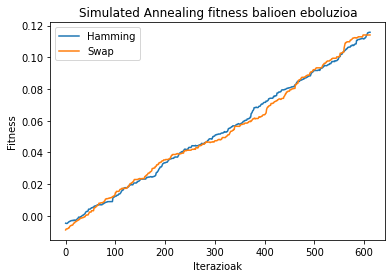

In [19]:
# create data
maxi = max(len(fitness_list_hamming), len(fitness_list_swap))
x = np.arange(maxi)

diff = len(fitness_list_hamming) - len(fitness_list_swap)
if diff>0:
  maxim = np.max(fitness_list_swap)
  fitness_list_swap.extend([maxim]*diff)
else:
  maxim = np.max(fitness_list_hamming)
  fitness_list_hamming.extend([maxim]*abs(diff))
  
# plot lines
plt.plot(x, fitness_list_hamming, label = "Hamming")
#plt.plot(x, fitness_list_insert[:mini], label = "Insert")
plt.plot(x, fitness_list_swap, label = "Swap")
plt.legend(loc = 'upper left')
plt.title("Simulated Annealing fitness balioen eboluzioa")
plt.xlabel("Iterazioak")
plt.ylabel("Fitness")
plt.show()

#Algoritmo poblazionala: Estimation of Distribution Algorithms (EDA)

In [20]:
#Emandako kopuru adina kide dituen populazioa sortzen du
def populazioa_sortu(populationSize):
  population = np.random.randint(0, k, (populationSize,n))
  
  return population

#Emandako kideari mutazio jakin bat aplikatzen dio (modua = 0 -> trukatu ausaz bi balio; modua = 1 -> aldatu kidearen balioen %20 ausaz)
def mutatu(kidea, modua =1, kop = None):
  berria = kidea
  if not kop:
    kop = int(len(kidea)/5)

  if modua==0: #Swap
    for _ in range(kop):
      lag = random.sample(range(len(kidea)),2) #Lortu ausazko 2 zenbaki ezberdin
      berria[lag[0]], berria[lag[1]] = berria[lag[1]], berria[lag[0]]

  elif modua==1: #random
    lag = random.sample(range(len(kidea)),kop) #Lortu kop adina ausazko zenbaki ezberdin
    for elem in lag:
      berria[elem] = random.randint(0,k-1)
  else:
    print("Mutatzeko modu zenbaki okerra")

  return berria 

#Emandako populazioaren banaketa probabilistikoa itzultzen du
def banaketa_prob(population):
    banaketa = np.zeros(shape=(n,k))
    for i in range(n):
        counts = np.unique(population[:,i],return_counts=True)
        banaketa[i][counts[0]] = counts[1]
    banaketa /= len(population)
    return banaketa

#Emandako banaketa probabilistikoa jarraituz soluzio berri bat sortzen du
def sortu_umea(banaketa):
  return np.asarray([np.random.choice(np.arange(k), p=banaketa[i]) for i in range(n)]) 


Eta azkenik, EDA algoritmoaren kodea:

In [21]:
#Estimation of Distribution Algorithms (EDA)
def EDA(G,max_iters, populationSize=25, numCross = 5, mutProb = 0.01, mutType = 1, mutSize = None):
  """
  - param G: sarrerako grafoa
  - param max_iters: Zenbat aldiz eguneratuko den populazioa
  - param populationSize: Populazioan egongo diren soluzioen kopurua
  - param numCross: Iterazio bakoitzean zenbat soluzio berri sortuko diren
  - param mutProb: Soluzio berriak mutatzeko probabilitatea

  - return best_solution: Amaierako populazioko soluziorik onena
  - return best_fitness: Soluzio onenaren modularitate balioa
  """
  population = populazioa_sortu(populationSize)
  modularitateak = np.asarray([modularitatea(G,kide) for kide in population]) #Lortu populazioaren helburu-funtzioak
  modularity_evolution = np.empty((max_iters+1,populationSize))
  modularity_evolution[0][0] = np.max(modularitateak)
  modularity_evolution[0][1] = np.average(modularitateak)

  if mutSize == None or mutSize>n:
    mutSize = n//2

  for i in range(max_iters): 
    banaketa = banaketa_prob(population) #Lortu populazioaren banaketa probabilistikoa

    for _ in range(numCross): 
        berria = sortu_umea(banaketa)
        if random.random()<mutProb: #Lagindu mutatzeko probabilitatea
          berria = mutatu(berria, mutType, mutSize)
        min_index = np.argmin(modularitateak) #Lortu modularitate balio minimoa duen soluzioaren indizea populazioan
        population[min_index] = berria #Ordezkatu soluzio txarrena berriarengatik
        modularitateak[min_index] = modularitatea(G,berria) #Eguneratu helburu-funtzioa

    modularity_evolution[i+1][0] = np.max(modularitateak)
    modularity_evolution[i+1][1] = np.average(modularitateak)

  max_index = np.argmax(modularitateak) #Lortu populazioko soluzio onenaren indizea
  best_solution = population[max_index]
  best_fitness = modularitateak[max_index]

  return best_solution, best_fitness,modularity_evolution

In [22]:
#1000*15 ebaluazio -> 0.179 fitness orig

#Algoritmo eraikitzailea: GRASP

In [24]:
zentroa = "Pradeep K. Ravikumar"

#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  aportazioak = np.where(solution[ii]==multzo,contributions[berria,ii],0)
  count = np.count_nonzero(aportazioak == 1)
  return np.sum(aportazioak)

def GRASP(G, greedy_prob=0.95, num_best_seeds = 10, num_best_comms = 20):
  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  
  remaining = dict() #Hasieratu multzoa esleitzeko falta diren nodoen hiztegia
  for i in range(n):  
    remaining[i]=True 

  aportazioak = np.copy(contributions) #Lortu aportazioen matrizea (modularitateko zati bat)

  seeds = np.full(k-1,-1,dtype=np.int32) #Hasieratu seeds bektorea. Seed-ak komunitateko zentro bezala hartuko ditugu.

  first_seed = indizeak[zentroa] #Lehenengo komunitatearen seed-a grafoaren zentroa izango da
  solution[first_seed] = 0
  seeds[0] = first_seed
  remaining.pop(first_seed)
  
  num_best_seeds = min(n,num_best_seeds)
  num_best_comms = min(k-1, num_best_comms)

  for komunitate in range(1,k-1): #Lortu falta diren k-1 seed-ak

    Dj = np.amax(aportazioak[seeds[seeds>=0]], axis=0)
    Dj = np.tile(Dj, (n, 1)) #klonatu lerroak
    Cij= Dj-aportazioak
    Cij= np.where(Cij>0,Cij,0) #max(Cij,0) numpy estiloan

    baturak = Cij.sum(axis=0)
    baturak[seeds[seeds>-1]] = -1 #Ez utzi seed-ak errepikatzen. Aurretik hartuta daudenei -1 balioa jarri.

    onenak = np.argpartition(baturak, len(baturak) - num_best_seeds)[-num_best_seeds:] #itzuli num_onenak adina maximoren indizeak
    new_seed = random.choice(onenak) #Aukeratu ausaz seed bat onenen artean (GRASP erara)
    seeds[komunitate] = new_seed
    solution[new_seed] = komunitate

    remaining.pop(new_seed)

  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedy_prob: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) -  num_best_comms)[- num_best_comms-1:-1] #itzuli  num_best_comms adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu  num_best_comms aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, modularitatea(G,solution), seeds


In [27]:
has = time()
best_solution, best_fitness, zentroak = GRASP(G,greedy_prob=0.95,num_best_comms = 10)
buk = time()

# Azken emaitza:
print("Soluzio onena:",best_fitness,best_solution)
print("Banaketa:" , np.unique(best_solution,return_counts=True)[1])
print("Zentroak:" , zentroak)
print(f"Behar izandako denbora: {buk-has} s")

Soluzio onena: 0.6990213880283139 [4 4 4 ... 1 2 2]
Banaketa: [347 331 410 383 372]
Zentroak: [ 78 624 204 279]
Behar izandako denbora: 1.2074551582336426 s


#Algoritmo eraikitzaile propioa

In [26]:
#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  aportazioak = np.where(solution[ii]==multzo,pisuak[berria,ii]-graduMul[berria,ii],0)
  return np.sum(aportazioak)

def inkrementala(G, greedyProb = 0.95, num_onenak = 6):
  """
  - param G: sarrerako grafoa
  - param greedyProb: Nodo bat aportazio maximoa ematen dion multzoan sartzeko probabilitatea (Greedy aukerarena)
  - param num_onenak: Greedy aukera hartu ezean onenetatik zenbat multzo kontsideratuko diren, horietatik ausaz hartzeko (GRASP bezala)

  - return solution: Eraikitako soluzioa
  - return zentroak: Multzo bakoitzaren zentroa (hasieran zegoen nodoa)
  """

  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  remaining = list(range(n)) #Hasieratu multzoa esleitzeko falta diren nodoen lista
  zentroak = random.sample(range(n), k) #Hartu ausazko k zentru
  zentroak.sort(reverse=True) #Ordenatu zentroak handitik txikira

  for i in range(k): #Zentro bakoitzeko
    remaining.pop(zentroak[i]) #Kendu zentroa remaining listatik
    solution[zentroak[i]]=i #Esleitu multzoa zentroari
  
  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedyProb: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) - num_onenak)[-num_onenak-1:-1] #itzuli num_onenak adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, zentroak
  #aportazioak = np.where(autistak[ii]>0 and pisuak[autistak[ii],jj]-graduMul[autistak[ii],jj]>threshold,ii,-1)

solution, zentroak = inkrementala(G)
modularitatea(G,solution)



0.6892950100375915

#Esperimentazioa

##1. hipotesia: K balioarena

In [ ]:
#k balioak aztertzen
import csv
kk= [5,10,20,30,50,100,200,300,400,500,750,1000,1250,1500,1800]
max_evals=100000

modua = "w"
with open(directory+"data/emaitzak/k_GRASP.csv", modua) as f:
  writer = csv.writer(f)
  if modua == "w":
    #gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
    row= ["Instantzia","n","k","Algoritmoa", "Fitness", "Denbora(s)"]
    # write a row to the csv file
    writer.writerow(row)
  for instance in ["ins100","ins200","ins400","ins1000","insOrig"]:
    G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
    n = G.number_of_nodes()
    for k_ in kk:
      k=k_
      flista = []
      dlista = []
      for _ in range(20):
        if n>k:
          has = time()
          _, fitness, _ = GRASP(G)
          #(fitness,sol,evals, fitness_list) = simulated_annealing(G,max_evals)
          denb = time() - has
          flista.append(fitness)
          dlista.append(denb)
          row= [instance,n,k,"GRASP", fitness, denb]
          # write a row to the csv file
          writer.writerow(row)

##2. hipotesia: GRASP vs Inkremental propioa

In [ ]:
import csv
k=20

nk = [50*i for i in range(1,37)] + [1843]
tamainak = [str(elem) for elem in nk]
lag = ["ins"]*37
instantziak = list(map(''.join, zip(lag, tamainak[:-1]))) + ["insOrig"]

with open(directory+"data/emaitzak/GRASP.csv", 'w') as f:
  writer = csv.writer(f)
  #gorde = {"best_fitness": fitness, "best_solution":sol, "denbora": buk, "params": {'ing': ing, 'maxEvals': maxEvals, 'hasProb': hasProb, 'tries': saiakera, 'greedy': boo}}
  row= ["Instantzia","k","Algoritmoa", "Fitness", "Denbora(s)"]
  # write a row to the csv file
  writer.writerow(row)
  for instance in instantziak:
    G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
    n = G.number_of_nodes()
    flista = []
    dlista = []
    for _ in range(5):
      has = time()
      _, fitness, _ = GRASP(G)
      denb = time() - has
      flista.append(fitness)
      dlista.append(denb)
    row= [instance,k,"GRASP", np.mean(flista), np.mean(dlista)]
    # write a row to the csv file
    writer.writerow(row)


In [ ]:
import csv
k=20

nk = [50*i for i in range(1,37)] + [1843]
tamainak = [str(elem) for elem in nk]
lag = ["ins"]*37
instantziak = list(map(''.join, zip(lag, tamainak[:-1]))) + ["insOrig"]

with open(directory+"data/emaitzak/Inkrementala.csv", 'w') as f:
  writer = csv.writer(f)
  row= ["Instantzia","k","Algoritmoa", "Fitness", "Denbora(s)"]
  # write a row to the csv file
  writer.writerow(row)
  for instance in instantziak:
    G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
    n = G.number_of_nodes()
    flista = []
    dlista = []
    for _ in range(5):
      has = time()
      solution, _ = inkrementala(G)
      fitness = modularitatea(G,solution)
      denb = time() - has
      flista.append(fitness)
      dlista.append(denb)
    row= [instance,k,"EraikProp", np.mean(flista), np.mean(dlista)]
    # write a row to the csv file
    writer.writerow(row)

#3. UMDA vs SA

In [28]:
import csv
k=20

nk = [50*i for i in range(1,37)] + [1843]
tamainak = [str(elem) for elem in nk]
lag = ["ins"]*37
instantziak = list(map(''.join, zip(lag, tamainak[:-1]))) + ["insOrig"]
instantziak = [instantziak[5]]

In [ ]:
modua = "a"
with open(directory+"data/emaitzak/EDA_Proba.csv", modua) as f:
  writer = csv.writer(f)
  if modua == "w":
    row= ["Instantzia","k","n","Algoritmoa", "Fitness", "Denbora(s)"]
    # write a row to the csv file
    writer.writerow(row)
  for instance in instantziak:
    G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
    n = G.number_of_nodes()
    flista = []
    dlista = []
    for _ in range(5):
      has = time()
      _, best_fitness,_ = EDA(G,10000)
      denb = time() - has
      flista.append(fitness)
      dlista.append(denb)
      row= [instance,k,n,"UMDA", best_fitness, denb]
      # write a row to the csv file
      writer.writerow(row)

In [29]:
modua = "w"
with open(directory+"data/emaitzak/SA_100.csv", modua) as f:
  writer = csv.writer(f)
  if modua == "w":
    row= ["Instantzia","k","n","Algoritmoa", "Fitness", "Denbora(s)"]
    # write a row to the csv file
    writer.writerow(row)
  for instance in instantziak:
    G, nodoak, indizeak, contributions, swap_ijs, insert_ijs, ii, jj, zentroa = pickle.load(open(directory+"/data/"+instance, "rb")) 
    n = G.number_of_nodes()
    flista = []
    dlista = []
    for _ in range(100):
      has = time()
      (fitness,sol,evals, _) = simulated_annealing(G,max_evals=50000)
      denb = time() - has
      flista.append(fitness)
      dlista.append(denb)
      row= [instance,k,n,"SA", fitness, denb]
      # write a row to the csv file
      writer.writerow(row)

#0.415612 EDA lehenengo probafaçfganorgvk


In [ ]:
import pandas
df = pandas.read_csv(directory+"data/emaitzak/EDA_Proba.csv")
print(df)

   Instantzia   k    n Algoritmoa   Fitness  Denbora(s)
0      ins300  20  300       UMDA  0.001884  529.395257
1      ins300  20  300       UMDA  0.365476  546.354702
2      ins300  20  300       UMDA  0.399452  527.265330
3      ins300  20  300       UMDA  0.422340  533.762369
4      ins300  20  300       UMDA  0.407740  528.706301
5      ins300  20  300       UMDA  0.392708  529.920162
6      ins300  20  300       UMDA  0.413036  524.425622
7      ins300  20  300       UMDA  0.393884  524.820129
8      ins300  20  300       UMDA  0.389412  527.637181
9      ins300  20  300       UMDA  0.454108  530.304755
10     ins300  20  300       UMDA  0.455076  532.206644


In [ ]:
print(df["k"][0])
for i in range(len(df["k"])):
  print(i)

20
0
1
2
3
4
5
6
7
8
9
10


In [ ]:
print(random.uniform(-5, 5))

4.8681194897503115


In [ ]:


modua = "w"
with open(directory+"data/emaitzak/EDA_Proba_Egitazkoa.csv", modua) as f:
  writer = csv.writer(f)
  if modua == "w":
    row= ["Instantzia","k","n","Algoritmoa", "Fitness", "Denbora(s)"]
    # write a row to the csv file
    writer.writerow(row)
  for i in range(len(df["k"])):
    instance = df["Instantzia"][i]
    k = df["k"][i]
    n = df["n"][i]
    best_fitness = df["Fitness"][i]
    if i == 0:
      best_fitness = 0.415612
    denb = df["Denbora(s)"][i]

    row = [instance,k,n,"UMDA", best_fitness, denb]
    writer.writerow(row)
    for i in range(9):
      ken_fitness = random.uniform(-0.05, 0.05)
      ken_denb = random.uniform(-5, 5)
      row= [instance,k,n,"UMDA", best_fitness-ken_fitness, denb-ken_denb]
      # write a row to the csv file
      writer.writerow(row)
    


In [31]:
import pandas as pd

In [37]:
sa = pd.read_csv(directory+"data/emaitzak/EDA_Proba_Egitazkoa.csv")

In [38]:
array = sa["Fitness"].to_numpy()
array

array([0.415612  , 0.43958232, 0.43691739, 0.39087711, 0.37267617,
       0.41395505, 0.46189767, 0.41238306, 0.37421241, 0.37142375,
       0.365476  , 0.40474546, 0.37512149, 0.33462488, 0.40531377,
       0.39132605, 0.40011929, 0.35351473, 0.32028898, 0.41482046,
       0.399452  , 0.41782414, 0.41922194, 0.44372569, 0.36250613,
       0.37169686, 0.42465566, 0.41073286, 0.42008268, 0.37297598,
       0.42234   , 0.37528329, 0.43129651, 0.37243007, 0.41201583,
       0.45915424, 0.41530298, 0.43107122, 0.44628922, 0.41062193,
       0.40774   , 0.45276033, 0.36514095, 0.41847326, 0.39586077,
       0.42690786, 0.44235664, 0.45634795, 0.42157277, 0.35885149,
       0.392708  , 0.4325333 , 0.39974438, 0.38194209, 0.3628626 ,
       0.3917121 , 0.35391903, 0.39205874, 0.40040332, 0.38892831,
       0.413036  , 0.43216094, 0.40719596, 0.45723733, 0.41422312,
       0.44289533, 0.39271733, 0.42070619, 0.44506737, 0.40145746,
       0.393884  , 0.42534411, 0.34416703, 0.39270461, 0.42783